In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

In [47]:
DATADIR = '/Users/johnfunk/Projects/machine-learning/ml-facial-gender/data'
CATEGORIES = ['Male', 'Female']

In [61]:
def create_training_data():
    
    data = []
    path = os.path.join(DATADIR)
    for img in os.listdir(path):
        x = re.search(r"\_(0|1)\_", img)
        if x == None:
            continue
        label = x.group(1)
        converted = cv2.imread(os.path.join(path,img))
        new = cv2.resize(converted, (100, 100))
        data.append([new, int(label)])

    return data

data = create_training_data()

In [62]:
print(data[0][1])

1


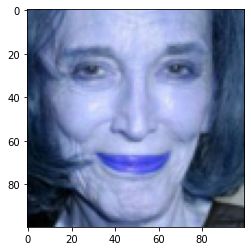

In [63]:
plt.imshow(data[200][0])

In [64]:
print(len(data))

7354


In [65]:
random.shuffle(data)

In [66]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, 100, 100, 3)
y = np.array(y)

In [67]:
print(X.shape)
print(y.shape)

(7354, 100, 100, 3)
(7354,)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=32)

In [80]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.01)))
model.add(layers.Dense(2))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20)

Train on 6986 samples
Epoch 1/20
6986/6986 [==============================] - 56s 8ms/sample - loss: 57.8470 - accuracy: 0.5763
Epoch 2/20
6986/6986 [==============================] - 54s 8ms/sample - loss: 2.1394 - accuracy: 0.6524
Epoch 3/20
6986/6986 [==============================] - 52s 7ms/sample - loss: 1.0880 - accuracy: 0.7214
Epoch 4/20
6986/6986 [==============================] - 51s 7ms/sample - loss: 1.0163 - accuracy: 0.7469
Epoch 5/20
6986/6986 [==============================] - 50s 7ms/sample - loss: 1.0113 - accuracy: 0.7537
Epoch 6/20
6986/6986 [==============================] - 51s 7ms/sample - loss: 0.9719 - accuracy: 0.7823
Epoch 7/20
6986/6986 [==============================] - 51s 7ms/sample - loss: 0.9157 - accuracy: 0.8022
Epoch 8/20
6986/6986 [==============================] - 49s 7ms/sample - loss: 0.8853 - accuracy: 0.8248
Epoch 9/20
6986/6986 [==============================] - 50s 7ms/sample - loss: 0.8329 - accuracy: 0.8464
Epoch 10/20
6986/6986 [=========

In [81]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

368/1 - 2s - loss: 0.6520 - accuracy: 0.8940

Test accuracy: 0.89402175


In [82]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test)
predictions[0]

array([0.99113536, 0.00886466], dtype=float32)

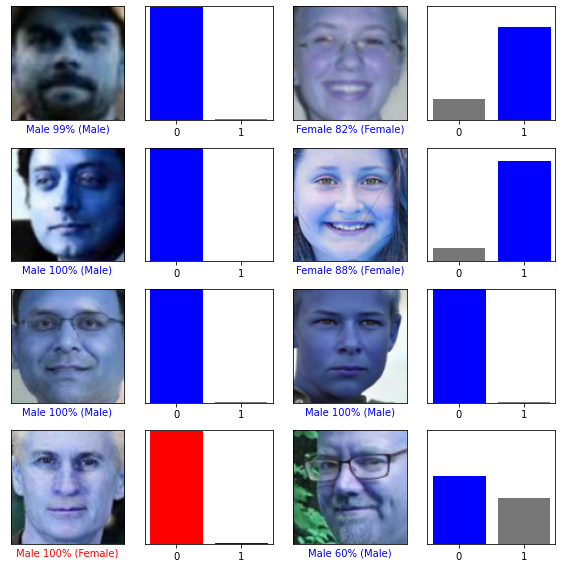

In [83]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(CATEGORIES[predicted_label],
                                100*np.max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


num_rows = 4
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()